Device: cpu

Imagen elegida al azar:
pruebas\ig2.jpg
Recorte guardado en temp_recortes/recorte.jpg (confianza 0.90)
Predicción: 83.31 / 100 (sin nota real en CSV)


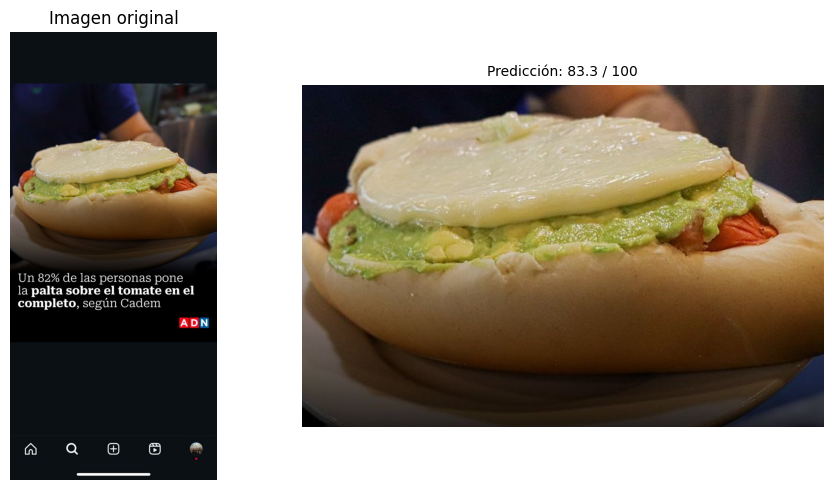

In [2]:
import os, random, cv2, math, torch, ast, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from torchvision import transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn as nn

BEST_PT = r"..\Detector completos\detector_completos\rf_completos\weights\best.pt" 
CROP_DIR = r"..\completos_regresion\v1 - Regresión simple\dataset\crops"
MERGED_CSV_PATH = r"..\completos_regresion\v1 - Regresión simple\dataset_regresion_extendido.csv"
IMG_SIZE = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

detector = YOLO(BEST_PT)

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
_mean, _std = weights.transforms().mean, weights.transforms().std
inference_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=_mean, std=_std),
])

model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(nn.Linear(in_f, 1), nn.Sigmoid())
model = model.to(device)
model.load_state_dict(torch.load(r"..\completos_regresion\v1 - Regresión simple\checkpoints\best_model.pth", map_location=device))
model.eval()

merged = pd.read_csv(MERGED_CSV_PATH)
if "score_clean" not in merged.columns:
    def clean_score_cell(x):
        try:
            if isinstance(x, str):
                data = ast.literal_eval(x)
                if isinstance(data, list) and data and isinstance(data[0], dict) and "number" in data[0]:
                    return float(data[0]["number"])
                return float(x)
            return float(x)
        except Exception:
            return None
    merged["score_clean"] = merged["score"].apply(clean_score_cell)
merged["img_path_norm"] = merged["img_path"].astype(str).apply(lambda x: x.replace("\\", "/"))

def detectar_y_recortar(imagen_path, conf_minima=0.5, clase_objetivo=0):
    """
    Usa el detector YOLO para extraer el recorte del completo más confiable.
    Retorna el path del recorte guardado (recorte.jpg).
    """
    img = cv2.imread(imagen_path)
    resultados = detector.predict(imagen_path, conf=conf_minima, verbose=False)

    mejor_box = None
    mejor_conf = 0.0
    for r in resultados:
        for box in r.boxes:
            if int(box.cls[0]) == clase_objetivo and box.conf[0] >= conf_minima:
                conf = float(box.conf[0])
                if conf > mejor_conf:
                    mejor_conf = conf
                    mejor_box = box.xyxy[0]

    if mejor_box is None:
        raise ValueError("No se detectó ningún completo en la imagen.")

    x1, y1, x2, y2 = map(int, mejor_box)
    recorte = img[y1:y2, x1:x2]

    os.makedirs("temp_recortes", exist_ok=True)
    crop_path = "temp_recortes/recorte.jpg"
    cv2.imwrite(crop_path, recorte)

    print(f"Recorte guardado en {crop_path} (confianza {mejor_conf:.2f})")
    return crop_path

def predecir_y_mostrar_con_real(ruta_imagen_original, split="test"):
    """
    Detecta el crop con YOLO, predice nota con MobileNet y muestra ambas imágenes.
    """
    # Detectar y recortar
    crop_path = detectar_y_recortar(ruta_imagen_original, conf_minima=0.4)
    img_original = Image.open(ruta_imagen_original).convert("RGB")
    img_crop = Image.open(crop_path).convert("RGB")

    # Inferencia con el modelo de regresión
    img_t = inference_tfms(img_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t).cpu().numpy().flatten()[0] * 100.0

    ruta_norm = ruta_imagen_original.replace("\\", "/")
    match = merged[merged["img_path_norm"].str.endswith(os.path.basename(ruta_norm), na=False)]
    real = float(match.iloc[0]["score_clean"]) if len(match) > 0 else None

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_original)
    axes[0].axis("off")
    axes[0].set_title("Imagen original")

    axes[1].imshow(img_crop)
    axes[1].axis("off")
    if real is not None:
        delta = abs(pred - real)
        axes[1].set_title(f"Crop evaluado\nReal: {real:.1f} | Pred: {pred:.1f}\nΔ={delta:.1f}", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100  |  Real: {real:.2f}  |  Δ={delta:.2f}")
    else:
        axes[1].set_title(f"Predicción: {pred:.1f} / 100", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100 (sin nota real en CSV)")

    plt.tight_layout()
    plt.show()

    return pred, real, crop_path

#carpeta = r"..\Detector completos\Dataset-Comida-Chilena-1\test\images"
carpeta = r"pruebas"

imagenes = glob.glob(os.path.join(carpeta, "*.jpg"))
ruta_aleatoria = random.choice(imagenes)

print(f"\nImagen elegida al azar:\n{ruta_aleatoria}")
pred, real, crop_path = predecir_y_mostrar_con_real(ruta_aleatoria, split="test")


Device: cuda


C:\Users\anays\AppData\Local\Temp\ipykernel_16252\286979555.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(BEST_MODEL_PATH, map_location=device)


Modelo EfficientNet-Lite0 cargado correctamente.

Imagen elegida al azar:
pruebas\ig1.jpg
Recorte guardado en temp_recortes/recorte.jpg (confianza 0.77)
Predicción: 72.23 / 100 (sin nota real en CSV)


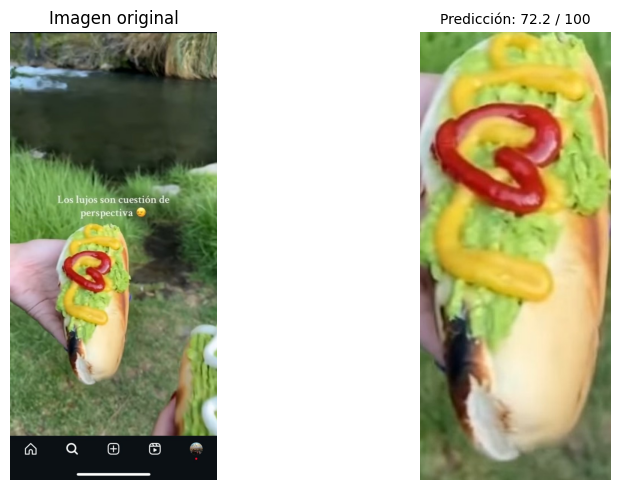

In [5]:
# =========================================================
# INFERENCIA COMPLETA CON EfficientNet-Lite0 + YOLO
# =========================================================
import os, random, cv2, math, torch, ast, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from torchvision import transforms
import timm
import torch.nn as nn
from pathlib import Path

# ---------------------------------------------------------
# CONFIGURACIONES GENERALES
# ---------------------------------------------------------
BEST_PT = r"..\Detector completos\detector_completos\rf_completos\weights\best.pt"
MERGED_CSV_PATH = r"..\completos_regresion\v1 - Regresión simple\dataset_regresion_extendido.csv"
BEST_MODEL_PATH = r"..\completos_regresion\v1 - Regresión simple\runs\effnet_lite0_regresion\best_model.pth"
IMG_SIZE = 240

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------------------------------------
# CARGAR DETECTOR YOLO
# ---------------------------------------------------------
detector = YOLO(BEST_PT)

# ---------------------------------------------------------
# TRANSFORMS para EfficientNet-Lite0
# ---------------------------------------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
inference_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ---------------------------------------------------------
# CARGAR MODELO EfficientNet-Lite0
# ---------------------------------------------------------
model = timm.create_model("efficientnet_lite0", pretrained=False)
in_f = model.classifier.in_features
model.classifier = nn.Sequential(nn.Linear(in_f, 1), nn.Sigmoid())
model = model.to(device)

state = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("Modelo EfficientNet-Lite0 cargado correctamente.")

# ---------------------------------------------------------
# CARGAR CSV CON NOTAS (para obtener valores reales)
# ---------------------------------------------------------
merged = pd.read_csv(MERGED_CSV_PATH)

if "score_clean" not in merged.columns:
    def clean_score_cell(x):
        try:
            if isinstance(x, str):
                data = ast.literal_eval(x)
                if isinstance(data, list) and data and isinstance(data[0], dict) and "number" in data[0]:
                    return float(data[0]["number"])
                return float(x)
            return float(x)
        except Exception:
            return None
    merged["score_clean"] = merged["score"].apply(clean_score_cell)

merged["img_path_norm"] = merged["img_path"].astype(str).apply(lambda x: x.replace("\\", "/"))

# ---------------------------------------------------------
# FUNCIÓN: DETECTAR Y RECORTAR CON YOLO
# ---------------------------------------------------------
def detectar_y_recortar(imagen_path, conf_minima=0.5, clase_objetivo=0):
    """
    Usa YOLO para extraer el recorte del completo más confiable.
    Retorna el path del recorte guardado (recorte.jpg).
    """
    img = cv2.imread(imagen_path)
    resultados = detector.predict(imagen_path, conf=conf_minima, verbose=False)
    mejor_box, mejor_conf = None, 0.0

    for r in resultados:
        for box in r.boxes:
            if int(box.cls[0]) == clase_objetivo and box.conf[0] >= conf_minima:
                conf = float(box.conf[0])
                if conf > mejor_conf:
                    mejor_conf = conf
                    mejor_box = box.xyxy[0]

    if mejor_box is None:
        raise ValueError("No se detectó ningún completo en la imagen.")

    x1, y1, x2, y2 = map(int, mejor_box)
    recorte = img[y1:y2, x1:x2]

    os.makedirs("temp_recortes", exist_ok=True)
    crop_path = "temp_recortes/recorte.jpg"
    cv2.imwrite(crop_path, recorte)

    print(f"Recorte guardado en {crop_path} (confianza {mejor_conf:.2f})")
    return crop_path

# ---------------------------------------------------------
# FUNCIÓN: PREDICCIÓN + VISUALIZACIÓN
# ---------------------------------------------------------
def predecir_y_mostrar_con_real(ruta_imagen_original):
    """
    Detecta el crop con YOLO, predice nota con EfficientNet-Lite0 y muestra resultados.
    """
    crop_path = detectar_y_recortar(ruta_imagen_original, conf_minima=0.4)
    img_original = Image.open(ruta_imagen_original).convert("RGB")
    img_crop = Image.open(crop_path).convert("RGB")

    # 🔹 Inferencia
    img_t = inference_tfms(img_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t).cpu().numpy().flatten()[0] * 100.0

    # 🔹 Buscar nota real (si está en el CSV)
    ruta_norm = ruta_imagen_original.replace("\\", "/")
    match = merged[merged["img_path_norm"].str.endswith(os.path.basename(ruta_norm), na=False)]
    real = float(match.iloc[0]["score_clean"]) if len(match) > 0 else None

    # 🔹 Mostrar comparación
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_original)
    axes[0].axis("off")
    axes[0].set_title("Imagen original")

    axes[1].imshow(img_crop)
    axes[1].axis("off")
    if real is not None:
        delta = abs(pred - real)
        axes[1].set_title(f"Crop evaluado\nReal: {real:.1f} | Pred: {pred:.1f}\nΔ={delta:.1f}", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100  |  Real: {real:.2f}  |  Δ={delta:.2f}")
    else:
        axes[1].set_title(f"Predicción: {pred:.1f} / 100", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100 (sin nota real en CSV)")

    plt.tight_layout()
    plt.show()

    return pred, real, crop_path

# ---------------------------------------------------------
# EJEMPLO DE USO (imagen aleatoria o carpeta "pruebas")
# ---------------------------------------------------------
carpeta = r"pruebas"  # cambia si quieres usar otra carpeta
imagenes = glob.glob(os.path.join(carpeta, "*.jpg"))
if not imagenes:
    raise FileNotFoundError(f"No se encontraron imágenes en {carpeta}")

ruta_aleatoria = random.choice(imagenes)
print(f"\nImagen elegida al azar:\n{ruta_aleatoria}")
pred, real, crop_path = predecir_y_mostrar_con_real(ruta_aleatoria)


✅ Modelos cargados correctamente.
Detector input: [  1 320 320   3]  → output: [   1    5 2100]
Regresor input: [  1   3 240 240]  → output: [1 1]
YOLO inference: 34.7 ms


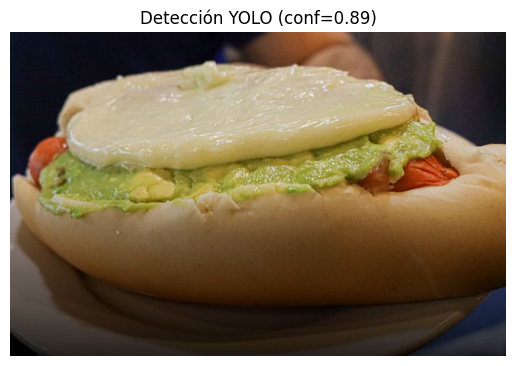

input_reg final: (1, 3, 240, 240)
Esperado por el modelo: [  1   3 240 240]
EfficientNet inference: 35.3 ms
🎯 Predicción final: 63.71 / 100


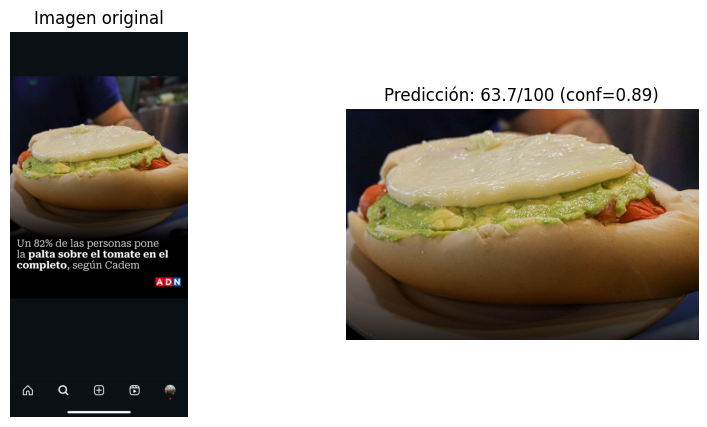

In [19]:
# =========================================================
# SIMULACIÓN DE FLUJO FLUTTER (TFLite YOLO + EfficientNet)
# =========================================================
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os, random, time

# ---------------------------------------------------------
# Rutas de tus modelos TFLite
# ---------------------------------------------------------
YOLO_TFLITE = r"..\Detector completos\detector_completos\rf_completos\weights\best_saved_model\best_float32.tflite"
REG_TFLITE = r"efficientnet_lite0.tflite"

# Imagen de prueba
IMAGEN = random.choice([
    r"pruebas\ig2.jpg",
])

# ---------------------------------------------------------
# Cargar intérpretes TFLite
# ---------------------------------------------------------
detector_interpreter = tf.lite.Interpreter(model_path=YOLO_TFLITE)
regresor_interpreter = tf.lite.Interpreter(model_path=str(REG_TFLITE))

detector_interpreter.allocate_tensors()
regresor_interpreter.allocate_tensors()

# ---------------------------------------------------------
# Obtener detalles de entrada/salida
# ---------------------------------------------------------
det_input = detector_interpreter.get_input_details()[0]
det_output = detector_interpreter.get_output_details()[0]
reg_input = regresor_interpreter.get_input_details()[0]
reg_output = regresor_interpreter.get_output_details()[0]

print("✅ Modelos cargados correctamente.")
print(f"Detector input: {det_input['shape']}  → output: {det_output['shape']}")
print(f"Regresor input: {reg_input['shape']}  → output: {reg_output['shape']}")

# ---------------------------------------------------------
# Preprocesar imagen para YOLO
# ---------------------------------------------------------
orig = cv2.imread(IMAGEN)
img = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (320, 320))  # tamaño del YOLO exportado
input_data = np.expand_dims(img_resized / 255.0, axis=0).astype(np.float32)

# ---------------------------------------------------------
# Inferencia YOLO (detección)
# ---------------------------------------------------------
detector_interpreter.set_tensor(det_input['index'], input_data)
t0 = time.time()
detector_interpreter.invoke()
t1 = time.time()

detections = detector_interpreter.get_tensor(det_output['index'])[0]  # (5, 2100)
print(f"YOLO inference: {(t1-t0)*1000:.1f} ms")

# ---------------------------------------------------------
# Interpretar detección más confiable
# ---------------------------------------------------------
boxes = detections.T  # (2100, 5)
best_idx = np.argmax(boxes[:, 4])  # columna 4 es conf
x, y, w, h, conf = boxes[best_idx, :5]

# 🔹 Convertir a coordenadas absolutas (x,y,w,h están normalizados)
H, W, _ = orig.shape
x1 = int((x - w / 2) * W)
y1 = int((y - h / 2) * H)
x2 = int((x + w / 2) * W)
y2 = int((y + h / 2) * H)

x1, y1 = max(x1, 0), max(y1, 0)
x2, y2 = min(x2, W - 1), min(y2, H - 1)

# ---------------------------------------------------------
# Recortar la detección
# ---------------------------------------------------------
crop = orig[y1:y2, x1:x2]
if crop.size == 0:
    raise ValueError("⚠️ No se detectó un completo válido en la imagen.")

# Visualizar recorte
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.title(f"Detección YOLO (conf={conf:.2f})")
plt.axis("off")
plt.show()

# ---------------------------------------------------------
# Preprocesar crop para EfficientNet
# ---------------------------------------------------------
IMG_SIZE = reg_input["shape"][2]  # 240
img_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
img_reg = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))

# Normalización [0,1] + ImageNet
img_reg = img_reg.astype(np.float32) / 255.0
img_reg = (img_reg - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

# 🔹 El modelo espera NCHW (1, 3, 240, 240)
img_reg = np.transpose(img_reg, (2, 0, 1))   # (HWC → CHW)
input_reg = np.expand_dims(img_reg, axis=0).astype(np.float32)

print("input_reg final:", input_reg.shape)
print("Esperado por el modelo:", reg_input["shape"])

# ---------------------------------------------------------
# Inferencia EfficientNet
# ---------------------------------------------------------
regresor_interpreter.set_tensor(reg_input['index'], input_reg)
t2 = time.time()
regresor_interpreter.invoke()
t3 = time.time()

pred = regresor_interpreter.get_tensor(reg_output['index']).flatten()[0]
pred_score = float(pred * 100.0)

print(f"EfficientNet inference: {(t3-t2)*1000:.1f} ms")
print(f"🎯 Predicción final: {pred_score:.2f} / 100")

# ---------------------------------------------------------
# Mostrar resultado final
# ---------------------------------------------------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.title(f"Predicción: {pred_score:.1f}/100 (conf={conf:.2f})")
plt.axis("off")
plt.show()


In [18]:
print("Esperado por el modelo:", reg_input["shape"])
print("input_reg actual:", input_reg.shape)


Esperado por el modelo: [  1   3 240 240]
input_reg actual: (1, 3, 3, 3)
